In [1]:
%reset -f

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, accuracy_score
%matplotlib inline

## Import the data

In [3]:
X=pd.read_csv('train_call.tsv', sep='\t')
y=pd.read_csv('train_clinical.txt', sep='\t', index_col=0)

## Transpose X and remove the first 4 rows

In [4]:
X = X.transpose()
X = X.tail(-4)

## Split to train and test data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Selection on training data

In [6]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel='linear')
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X_train, y_train.values.ravel())
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 12


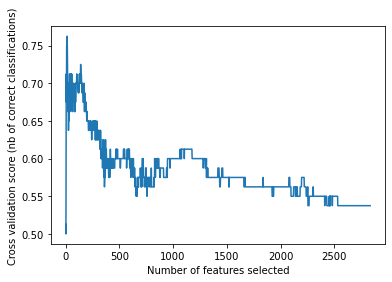

In [7]:
# Get the cross-validation scores
cv_scores = rfecv.cv_results_['mean_test_score']

# Plot number of Features Vs Cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(cv_scores) + 1), cv_scores)
plt.show()

In [8]:
features = list(X_train.columns[rfecv.support_])
print('Best features :', features)

Best features : [230, 396, 746, 1663, 1882, 1897, 1973, 2024, 2026, 2184, 2210, 2750]


In [9]:
X_train, X_test = X_train.filter(features), X_test.filter(features)

In [10]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train.values.ravel())
print('RF Classifier Training Accuracy:', rf_classifier.score(X_train, y_train))

RF Classifier Training Accuracy: 1.0


In [11]:
# Create custom scorers
scorers = {
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'mse': make_scorer(mean_squared_error, greater_is_better=False)
}

In [13]:
# Split the data into training and validation sets (80/20 split)
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

# RF with Hyper Parameters Tuning
RF_0 = RandomForestClassifier(random_state=42)

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

# Use the validation set for cross-validation during hyperparameter optimization
RF_1 = GridSearchCV(RF_0, param_grid=params, n_jobs=-1, cv=[(list(range(len(X_train_split))), list(range(len(X_train_split), len(X_train))))], scoring=scorers, refit = 'mae')
RF_1.fit(X_train, y_train.values.ravel())

print("Best Hyper Parameters:\n", RF_1.best_params_)

Best Hyper Parameters:
 {'max_depth': None, 'n_estimators': 50}


C:\Users\nikos\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [14]:
# Calculate the training and validation scores
print('SVM Classifier Training Accuracy:', RF_1.score(X_train_split, y_train_split))
print('SVM Classifier Validation Accuracy:', RF_1.score(X_val, y_val))

ValueError: could not convert string to float: 'Triple Neg'

In [ ]:
# Compare the training and validation scores
if abs(RF_1.score(X_train_split, y_train_split) - RF_1.score(X_val, y_val)) <= 0.051:
    print("The model is not overfitting.")
else:
    print("The model might be overfitting.")